## BTC Option Volatility Time Series

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
plt.rcParams["figure.figsize"] = (16, 10)

### Generate underlying index price time series

At the moment we do not record the index prices so it must be obtained from option data by naively assuming that the largest data file contains the most index price data. Fix this in future.

In [160]:
csv_path = '/home/fp361/cloud-mounts/deribit_orderbook_data/'

In [2]:
import os

In [8]:
csv_list = os.listdir(csv_path)

pairs = []
for file in csv_list:

    location = os.path.join(csv_path, file)

    size = os.path.getsize(location)
    pairs.append((size, file))

pairs.sort(key=lambda s: s[0])

pairs.reverse()
largest = pairs[0]
print(largest)

(3998046, 'BTC-26JUN20-10000-C.csv')


In [15]:
index_prices = pd.read_csv(os.path.join(csv_path, largest[1])).filter(['timestamp', 'index_price'])
index_prices['timestamp'] = pd.to_datetime(index_prices['timestamp'], unit='ms')
index_prices = index_prices.set_index('timestamp')
index_prices

,index_price
timestamp,
2020-03-29 17:47:26.103,6109.09
2020-03-29 17:49:28.971,6106.87
2020-03-29 17:51:04.636,6106.81
2020-03-29 17:52:41.308,6108.52
2020-03-29 17:56:53.093,6115.78
...,...
2020-04-14 16:26:50.293,6935.91
2020-04-14 16:30:38.352,6949.25
2020-04-14 16:33:26.850,6952.71


In [18]:
index_prices_5min = pd.DataFrame()
index_prices_5min['index_price'] = index_prices.index_price.resample('5min').last()
index_prices_5min

,index_price
timestamp,
2020-03-29 17:45:00,6106.87
2020-03-29 17:50:00,6108.52
2020-03-29 17:55:00,6115.78
2020-03-29 18:00:00,6103.32
2020-03-29 18:05:00,6100.00
...,...
2020-04-14 16:15:00,6945.95
2020-04-14 16:20:00,6939.12
2020-04-14 16:25:00,6935.91


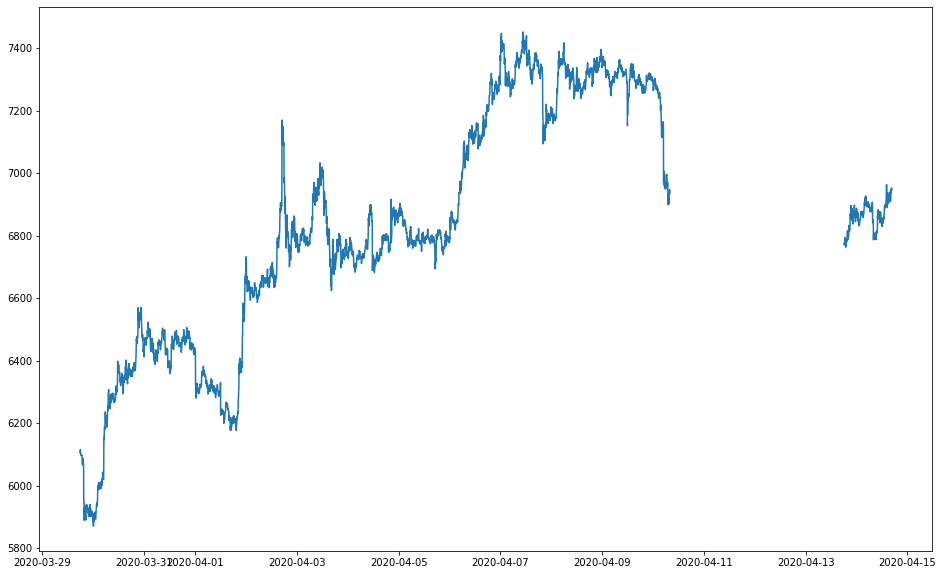

In [20]:
plt.plot(index_prices_5min)

## VIX time series

Start from 6pm GMT 29-03-2020.

In [224]:
now = pd.to_datetime('2020-03-29 18:00:00')

### Get near-term and next-term expiry dates given current time

Current implementation returns the dates of the next two Fridays. Cutoff point is the same as Deribit option expiry time - Friday 08:00 UTC.

(Deribit BTC Options Contract Specification: https://www.deribit.com/pages/docs/options)

In [190]:
import calendar
from datetime import datetime

In [191]:
def format_datetime_to_expiry(date):
    return datetime.strftime(date, '%-d%b%y').upper()

def get_near_next_terms(now):
    c = calendar.Calendar(firstweekday=calendar.MONDAY)
    
    this_month_cal = c.monthdatescalendar(now.year, now.month)
    this_fridays = [datetime(day.year, day.month, day.day, 8, 0, 0) 
                    for week in this_month_cal for day in week 
                    if day.weekday() == calendar.FRIDAY and day.month == now.month 
                    and datetime(day.year, day.month, day.day, 8, 0, 0) >= now]
    
    next_year = now.year if now.month < 12 else now.year + 1
    next_month = now.month + 1 if now.month < 12 else 1
    
    next_month_cal = c.monthdatescalendar(next_year, next_month)
    next_fridays = [datetime(day.year, day.month, day.day, 8, 0, 0) 
                    for week in next_month_cal for day in week 
                    if day.weekday() == calendar.FRIDAY and day.month == next_month 
                    and datetime(day.year, day.month, day.day, 8, 0, 0) >= now]
    
    '''
    if len(this_fridays) < 1:
        near_term = next_fridays[0]
        next_term = next_fridays[-1]
    elif len(this_fridays) < 2:
        near_term = this_fridays[-1]
        next_term = next_fridays[0]
    else:
        near_term = fridays[0]
        next_term = fridays[1]
        
    '''
    
    fridays = this_fridays + next_fridays
    
    near_term, next_term = fridays[0], fridays[1]
        
    return (format_datetime_to_expiry(near_term), format_datetime_to_expiry(next_term))

Test:

In [199]:
near_expiry, next_expiry = get_near_next_terms(now)
near_expiry, next_expiry

('3APR20', '10APR20')

### Load required orderbook data

In [196]:
import glob

# Shorthand for dictionary lookup
co = 'C' # Call option
po = 'P' # Put option

In [250]:
def read_orderbook_data(csv_path, expiry, data_dict=dict()):
    near_next_csv = glob.glob(csv_path + f'BTC-{expiry}-*-*.csv')

    if expiry not in data_dict:
        data_dict[expiry] = dict()
    else:
        # Already read
        return data_dict

    for file_path in near_next_csv:
        instrument = os.path.basename(file_path).split('-')
        exp, strike, cp = instrument[1], int(instrument[2]), instrument[3].split('.')[0]  

        if strike not in data_dict[exp]:
            data_dict[exp][strike] = dict()
            
        df = pd.read_csv(file_path).filter(['timestamp', 'best_bid_price', 'best_ask_price'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df.set_index('timestamp')
        df_resampled = df.resample('5min').last()
            
        data_dict[exp][strike][cp] = df_resampled
        
    return data_dict        

Test:

In [200]:
# This call should return a five-minute resampled time-series dataframe of best bids and asks for BTC-3APR20-6750-C.
read_orderbook_data(csv_path, near_expiry)[near_expiry][6750][co]

,best_bid_price,best_ask_price
timestamp,,
2020-03-29 17:45:00,0.0090,0.0110
2020-03-29 17:50:00,0.0090,0.0110
2020-03-29 17:55:00,0.0090,0.0110
2020-03-29 18:00:00,0.0090,0.0110
2020-03-29 18:05:00,0.0090,0.0110
...,...,...
2020-04-03 07:40:00,0.0190,0.0310
2020-04-03 07:45:00,0.0220,0.0300
2020-04-03 07:50:00,0.0220,0.0300


### VIX calculation

In [260]:
orderbook_data = dict()
orderbook_data = read_orderbook_data(csv_path, near_expiry)
orderbook_data = read_orderbook_data(csv_path, next_expiry, orderbook_data)

In [257]:
def calculate_mid_diff(option):
    call_df, put_df = option[co], option[po]
    
    option_prices = call_df.copy()
    option_prices['call_price'] = (call_df['best_bid_price'] + call_df['best_ask_price']) / 2
    option_prices['put_price'] = (put_df['best_bid_price'] + put_df['best_ask_price']) / 2
    option_prices  = option_prices.filter(['call_price', 'put_price'])
    
    option_prices['abs_diff'] = (option_prices['call_price'] - option_prices['put_price']).abs()
    
    return option_prices

def find_min_diff(expiry, time):
    strike_diffs = dict()
    
    for strike in expiry.keys():
        strike_diffs[strike] = expiry[strike]['prices'].loc[time]['abs_diff']
        
    sorted_strikes = {k: v for k, v in sorted(strike_diffs.items(), key=lambda item: item[1])}
    
    return sorted_strikes

In [266]:
for expiry in orderbook_data.keys():
    strike_diffs = dict()
    
    for strike in orderbook_data[expiry].keys():
        orderbook_data[expiry][strike]['prices'] = calculate_mid_diff(orderbook_data[expiry][strike])
        strike_diffs[strike] = orderbook_data[expiry][strike]['prices'].loc[now]['abs_diff']
        
    sorted_strikes = [k for k, v in sorted(strike_diffs.items(), key=lambda item: item[1])]
    print(sorted_strikes[0])

8500


KeyError: Timestamp('2020-03-29 18:00:00')

In [274]:
orderbook_data[next_expiry][6500]['prices'].loc[now]

call_price    0.041
put_price     0.103
abs_diff      0.062
Name: 2020-03-29 18:00:00, dtype: float64

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs
